In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy.stats as stats
import scipy.special as spec
from scipy.optimize import curve_fit
from numba_stats import expon
# from numba_stats import norm

# Run and Tumble Particle

Langevin Equation For a Run and Tumble Particle

$$ \frac{dx}{dt} = f(x) + v_0 \sigma (t)$$

where $\sigma(t)$ is a telegraphic noise which switches between $\pm v_0$

In [2]:
@njit
def Model(x_0, v_0, tau, DT):
    nsteps = len(tau)
    x = np.zeros(nsteps)
    x[0] = x_0
    alpha = 2
    mu = 1
    for i in range(0, nsteps-1):
        force = -mu * np.sign(x[i])*(np.abs(x[i]) ** (alpha - 1))
        # print(force)
        x[i+1] = x[i] + force * DT + v_0 * tau[i] * DT
        # print(x[i])
    return x

In [3]:
@njit
def tn(x, pp):
    teln = np.ones(len(x))
    prevk = 0
    fl = -1
    for i in pp:
        k = np.argmax(x>=i)
        # print(x[k])
        teln[prevk:k:] = fl
        prevk = k
        fl*=-1
    return teln

In [4]:
def TelNoise(gamma, n):
    exp = stats.expon
    exprv = exp.rvs(scale = 1/gamma, size = n)
    return exprv

In [5]:
def ModelGen(size, gamma, x_0, v_0, t_e):
    exp = stats.expon
    tauarr = exp.rvs(scale = 1/gamma, size = size)
    cumtau = tauarr.cumsum()
    ind = np.argmax(cumtau >= t_e)
    TauArr = list(cumtau[:ind:])
    tau = list(tauarr[:ind:])
    end = t_e - TauArr[-1]
    TauArr.insert(0, 0)
    TauArr.append(t_e)
    tau.append(end)
    fl = 1
    l = len(TauArr)
    x = np.zeros(l)
    mu = 1
    alpha = 2
    x[0] = x_0
    print(tau)
    for i in range(1, l):
        force = - mu * np.sign(x[i-1]) * (np.abs(x[i-1])**(alpha-1))
        x[i] = x[i-1] + force * tau[i-1] + v_0 * fl * tau[i-1]
        fl*=-1
    return tau, x, TauArr

# Model 2

Discard Above

In [6]:
@njit(fastmath = True)
def rvexpon(gamma):
    return expon.rvs(0, scale=1/gamma, size = 1, random_state = 1)

In [30]:
# @jit
def ModelGen2(x_0, v_0, gamma, t_e, MU, A, nDT):
    timesum = 0
    exp = stats.expon
    flag = True
    # tt = [0.]
    posn =[x_0]
    temposn = [x_0]
    fl = 1
    while flag == True:
       t =  exp.rvs(scale = 1/gamma)
       s = timesum + t
       if s < t_e:
           timesum += t
           DT = t/nDT
           for i in range(0, nDT-1):
               force = -MU * np.sign(temposn[i]) * (np.abs(temposn[i])**(A-1))
               temposn.append(temposn[i] +  force * DT + v_0 * fl * DT)
           fl*=-1
           posn.extend(temposn[1::])
           endpt = temposn[-1]
           temposn = [endpt]
       elif s == t_e:
           timesum += t
           DT = t/nDT
           for i in range(0, nDT-1):
               force = -MU * np.sign(temposn[i]) * (np.abs(temposn[i])**(A-1))
               temposn.append(temposn[i] +  force * DT + v_0 * fl * DT)
           fl*=-1
           posn.extend(temposn[1::])
           flag = False
       else:
           endt = t_e - timesum
           timesum += endt
           DT = endt/nDT
           for i in range(0, nDT-1):
               force = -MU * np.sign(temposn[i]) * (np.abs(temposn[i])**(A-1))
               temposn.append(temposn[i] +  force * DT + v_0 * fl * DT)
           fl*=-1
           posn.extend(temposn[1::])
           flag = False
    return posn

In [8]:
# @jit
def dtmModel(x_0, v_0, nDT, t_e, MU, A):
    # timesum = 0
    # flag = True   
    fl = 1
    # nDT = 1000
    temposn = np.zeros(nDT)
    temposn[0] = x_0

    DT = t_e/nDT
    
    
    for i in range(0, nDT-1):
        force = -MU * np.sign(temposn[i]) * (np.abs(temposn[i])**(A-1))
        temposn[i+1] = temposn[i] +  force * DT + v_0 * fl * DT
    
    # while flag == True:
    #    t =  exp.rvs(scale = 1/gamma)
    #    s = timesum + t
    #    if s < t_e:
    #        timesum += t
    #        DT = t/nDT
    #        for i in range(0, nDT-1):
    #            force = -MU * np.sign(temposn[i]) * (np.abs(temposn[i])**(A-1))
    #            temposn.append(temposn[i] +  force * DT + v_0 * fl * DT)
    #        fl*=-1
    #        posn.extend(temposn)
    #        endpt = temposn[-1]
    #        temposn = [endpt]
    #    elif s == t_e:
    #        timesum += t
    #        DT = t/nDT
    #        for i in range(0, nDT-1):
    #            force = -MU * np.sign(temposn[i]) * (np.abs(temposn[i])**(A-1))
    #            temposn.append(temposn[i] +  force * DT + v_0 * fl * DT)
    #        fl*=-1
    #        posn.extend(temposn)
    #        flag = False
    #    else:
    #        endt = t_e - timesum
    #        timesum += endt
    #        DT = endt/nDT
    #        for i in range(0, nDT-1):
    #            force = -MU * np.sign(temposn[i]) * (np.abs(temposn[i])**(A-1))
    #            temposn.append(temposn[i] +  force * DT + v_0 * fl * DT)
    #        fl*=-1
    #        posn.extend(temposn)
    #        flag = False
    return temposn

In [5]:
def prob(x, g, mu, v_0):
    fr = g/mu
    phi = fr -1
    bet = spec.beta(fr, fr)
    p = 2/(4**fr * bet) * (mu/v_0) *(1 - (mu*x/v_0)**2)**phi
    return p
    

In [10]:
def linfit(x, a, b):
    return a*x+b

In [ ]:
def Measured():
    
    return None

In [3]:
# @jit
def ModelGen3(x_0, v_0, gamma, t_e, MU, A, DT):
    timesum = 0
    exp = stats.expon
    flag = True
    # tt = [0.]
    posn =[x_0]
    temposn = [x_0]
    fl = 1
    while flag == True:
       t =  exp.rvs(scale = 1/gamma)
       s = timesum + t
       if s < t_e:
           timesum += t
           nDT = int(t/DT)
           for i in range(0, nDT-1):
               force = -MU * np.sign(temposn[i]) * (np.abs(temposn[i])**(A-1))
               temposn.append(temposn[i] +  force * DT + v_0 * fl * DT)
           fl*=-1
           posn.extend(temposn[1::])
           endpt = temposn[-1]
           temposn = [endpt]
       elif s == t_e:
           timesum += t
           nDT = int(t/DT)
           for i in range(0, nDT-1):
               force = -MU * np.sign(temposn[i]) * (np.abs(temposn[i])**(A-1))
               temposn.append(temposn[i] +  force * DT + v_0 * fl * DT)
           fl*=-1
           posn.extend(temposn[1::])
           flag = False
       else:
           endt = t_e - timesum
           timesum += endt
        #    print(endt)
           nDT = int(endt/DT)
           for i in range(0, nDT-1):
               force = -MU * np.sign(temposn[i]) * (np.abs(temposn[i])**(A-1))
               temposn.append(temposn[i] +  force * DT + v_0 * fl * DT)
           fl*=-1
           posn.extend(temposn[1::])
           flag = False
    return posn

/tmp/ipykernel_1077/2621421318.py:5: RuntimeWarning: divide by zero encountered in power
  p = 2/(4**fr * bet) * (mu/v_0) *(1 - (mu*x/v_0)**2)**phi


(-0.75, 15.0)

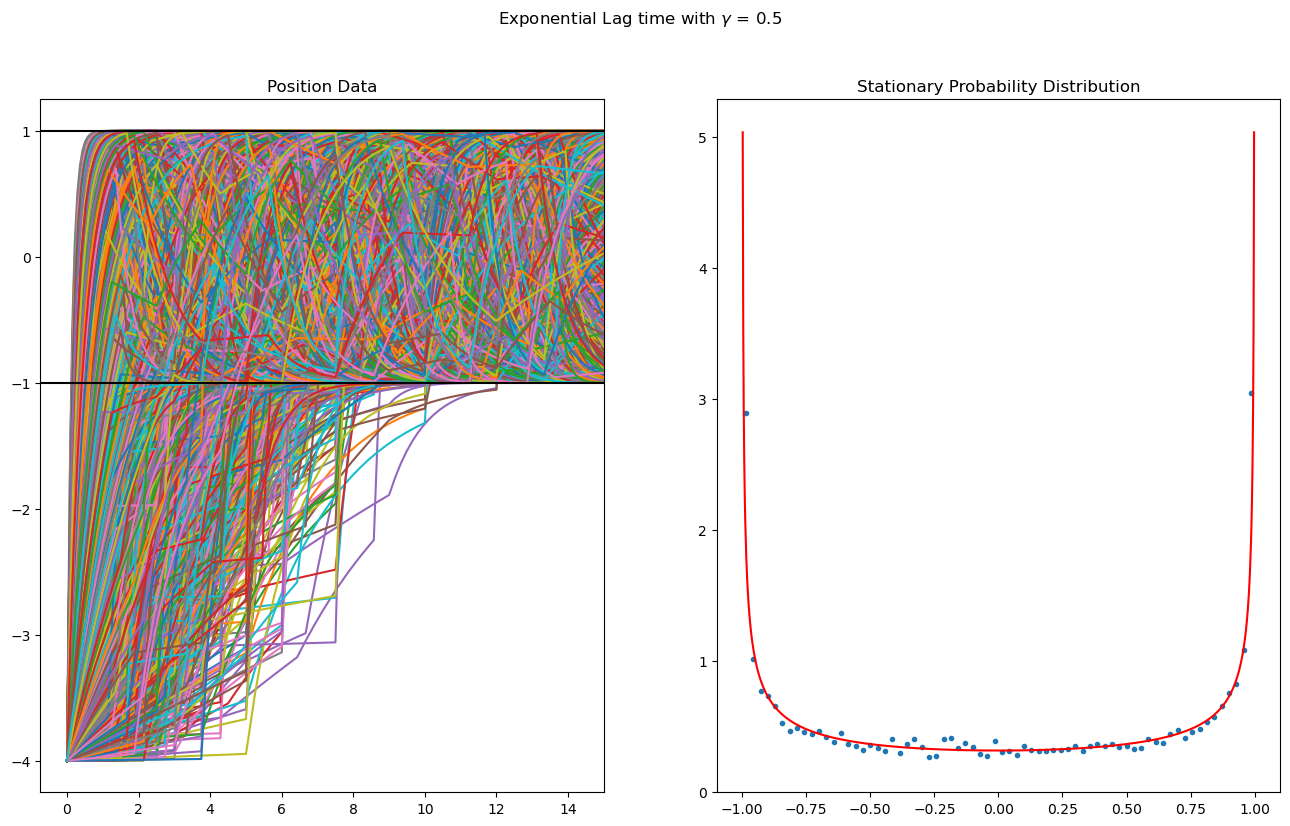

In [33]:
x_0 = -4
v_0 = 1
A = 2
mu = 1
gamma = .5
t_e = 15
# nsteps = 5
NUM =10000
fig,axes = plt.subplots(1,2, figsize = (16,9))
fig.suptitle(r"Exponential Lag time with $\gamma$ = "+str(gamma))
step = np.zeros(NUM)
for i in range(0,NUM):    
    c = ModelGen2(x_0, v_0, gamma, t_e, mu, A, 20)
    posnobsfl = np.array(c)
    nsteps = len(posnobsfl)
    time = np.linspace(0,t_e, nsteps)
    step[i] = posnobsfl[-1]
    axes[0].plot(time, posnobsfl)


n,bins, patches = axes[1].hist(step, bins = 70, density = True, color = 'w');

# Now we find the center of each bin from the bin edges
bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]
# axes[1] = fig.add_subplot(122)
# axes[1].scatter(bins_mean, n,marker="$\u26AA$" )
axes[1].scatter(bins_mean, n,marker="." )
axes[1].set_title("Stationary Probability Distribution")
axes[0].set_title("Position Data")

lll = np.linspace(-1,1, 1000)
lly = prob(lll, gamma, mu, v_0)
axes[1].plot(lll,lly, color ='red')
axes[0].axhline(v_0/mu, color = 'black')
axes[0].axhline(-v_0/mu, color = 'black')
axes[0].set_xlim(right = t_e)
# fig.savefig("RunandTumblegamma1pt5.png")


## Variation with $x_0$

We vary x_0 between x_low x_high and see how the time when it enters the stationary phase

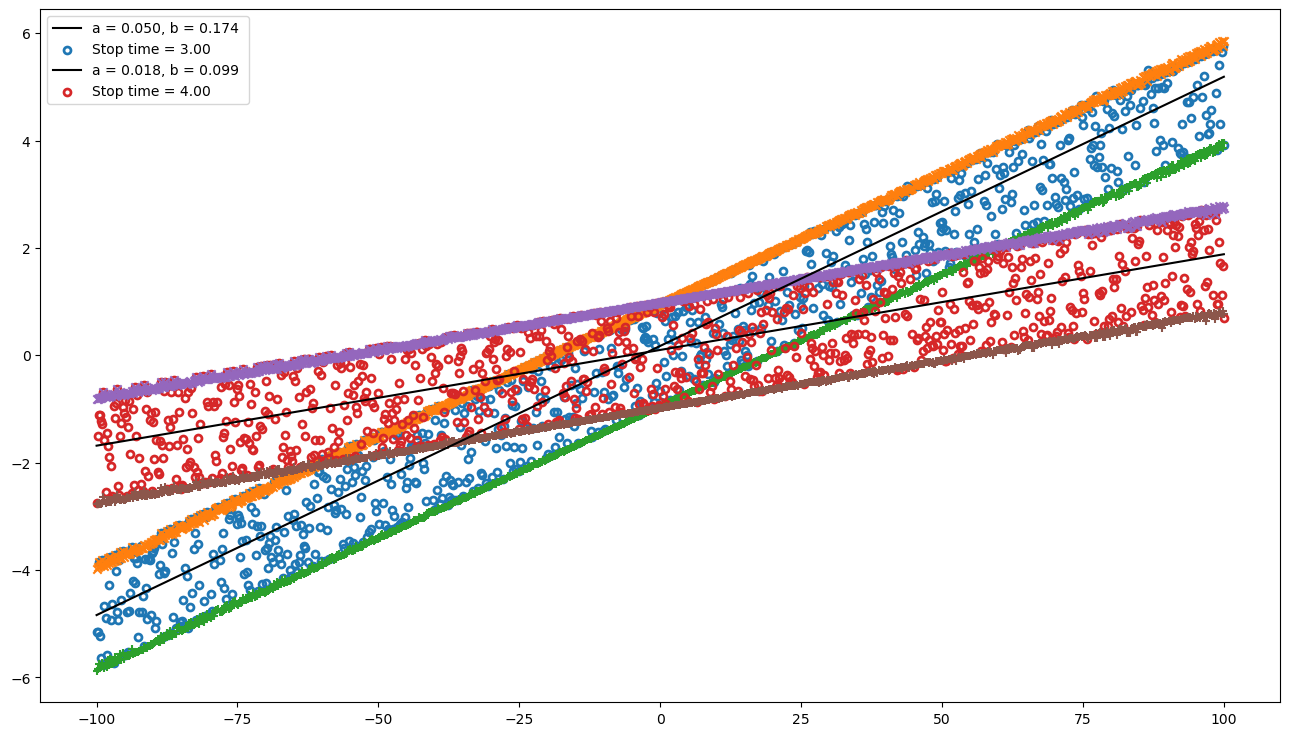

In [167]:
NUM = 1000
x_l = -100
x_h = 100
x_0 = np.linspace(x_l,x_h,NUM)
v_0 = 1
A = 2
mu = 1
gamma = .5

t_e = [3,4]

fig,axes = plt.subplots(1,1, figsize = (16,9))
# fig2,axes2 = plt.subplots(1,1, figsize = (16,9))
step = np.zeros(NUM)
stepdtm = np.zeros(NUM)
stepdtminv = np.zeros(NUM)
for k in range(0, len(t_e)):
    for i in range(0,NUM):    
        c = ModelGen2(x_0[i], v_0, gamma, t_e[k], mu, A)
        posndtm = dtmModel(x_0[i], v_0, len(c), t_e[k], mu, A)
        posndtminv = dtmModel(x_0[i], -v_0, len(c), t_e[k], mu, A)
        
        posnobsfl = np.array(c)
        nsteps = len(posnobsfl)
        time = np.linspace(0,t_e[k], nsteps)
        step[i] = posnobsfl[-1]
        stepdtm[i] = posndtm[-1]
        stepdtminv[i] =posndtminv[-1]
        # axes2.plot(time, posnobsfl)
        # axes2.plot(time, posndtm)
        # axes2.plot(time, posndtminv)
        
    # axes.scatter(x_0, step,marker=".",label =f"Stop time = %.2f"%t_e[k])
    param, paramcov = curve_fit(linfit, x_0, step)
    axes.plot(x_0, linfit(x_0, *param), label = f"a = %.3f, b = %.3f "%(param[0], param[1]), color = 'k')
    axes.scatter(x_0, step,marker="$\u26AA$",label =f"Stop time = %.2f"%t_e[k])
    axes.scatter(x_0, stepdtm,marker="x")
    axes.scatter(x_0, stepdtminv,marker="+")
    
axes.legend()

/tmp/ipykernel_1515/2621421318.py:5: RuntimeWarning: divide by zero encountered in power
  p = 2/(4**fr * bet) * (mu/v_0) *(1 - (mu*x/v_0)**2)**phi


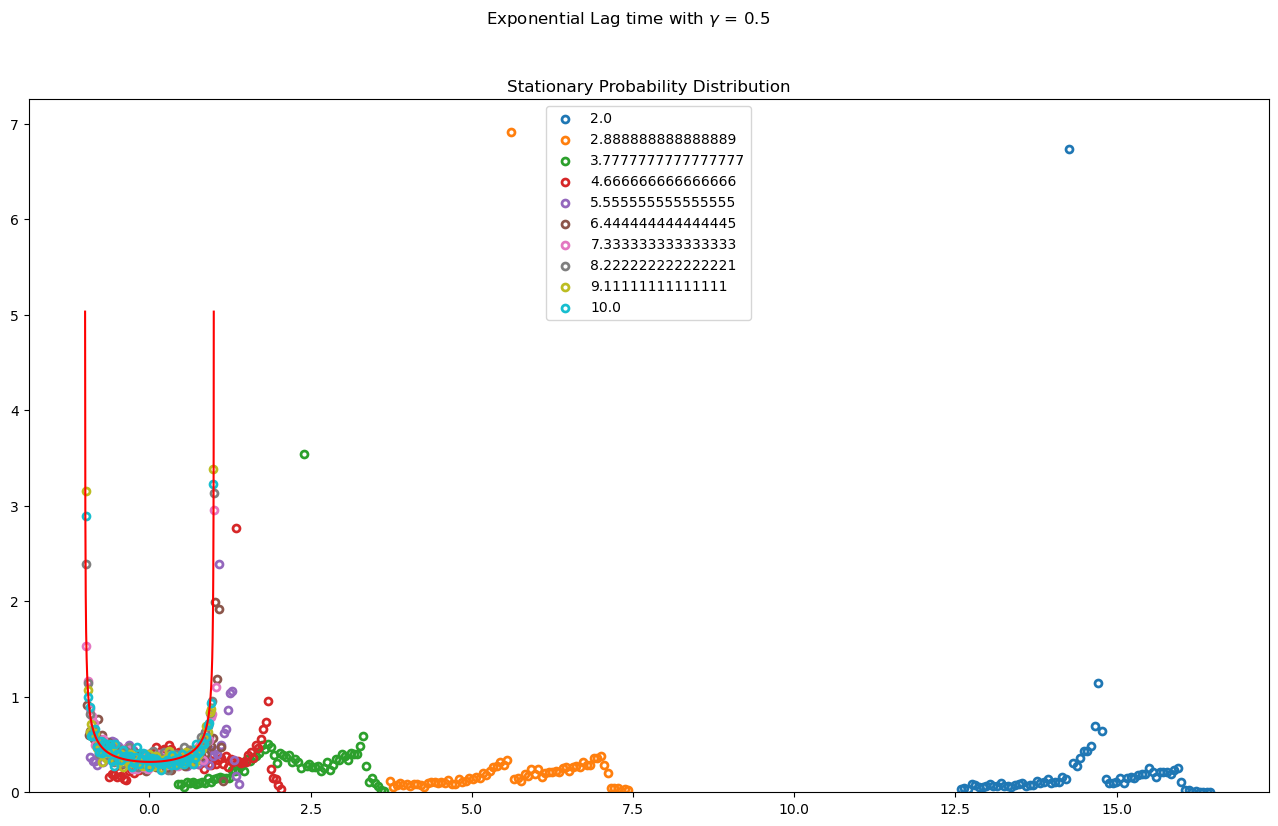

In [38]:
x_0 = 100
v_0 = 1
A = 2
mu = 1
gamma = .5
nt = 10
t_e = np.linspace(2,10,nt)
# nsteps = 5
NUM =5000
fig,axes = plt.subplots(1,1, figsize = (16,9))
fig.suptitle(r"Exponential Lag time with $\gamma$ = "+str(gamma))
step = np.zeros((nt, NUM))
for k in range(0, nt):
    for i in range(0,NUM):    
        c = ModelGen2(x_0, v_0, gamma, t_e[k], mu, A, 10)
        posnobsfl = np.array(c)
        nsteps = len(posnobsfl)
        time = np.linspace(0,t_e[k], nsteps)
        step[k][i] = posnobsfl[-1]
        # axes[0].plot(time, posnobsfl)
    n,bins, patches = axes.hist(step[k], bins = 70, density = True, facecolor = 'None');

    # Now we find the center of each bin from the bin edges
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]
    # axes[1] = fig.add_subplot(122)
    axes.scatter(bins_mean, n,marker="$\u26AA$", label =str(t_e[k]) )
    axes.set_title("Stationary Probability Distribution")
    # axes[0].set_title("Position Data")

lll = np.linspace(-1,1, 1000)
lly = prob(lll, gamma, mu, v_0)
axes.plot(lll,lly, color ='red')
# axes[0].axhline(v_0/mu, color = 'black')
# axes[0].axhline(-v_0/mu, color = 'black')
# for i in range(0, nt):
#     axes[0].axvline(t_e[i], color = 'red')
# axes[0].set_xlim(right = t_e[-1])
axes.legend()
# fig.savefig("RunandTumblegamma1pt5.png")


# Time Evolution of Moments of the probability distribution

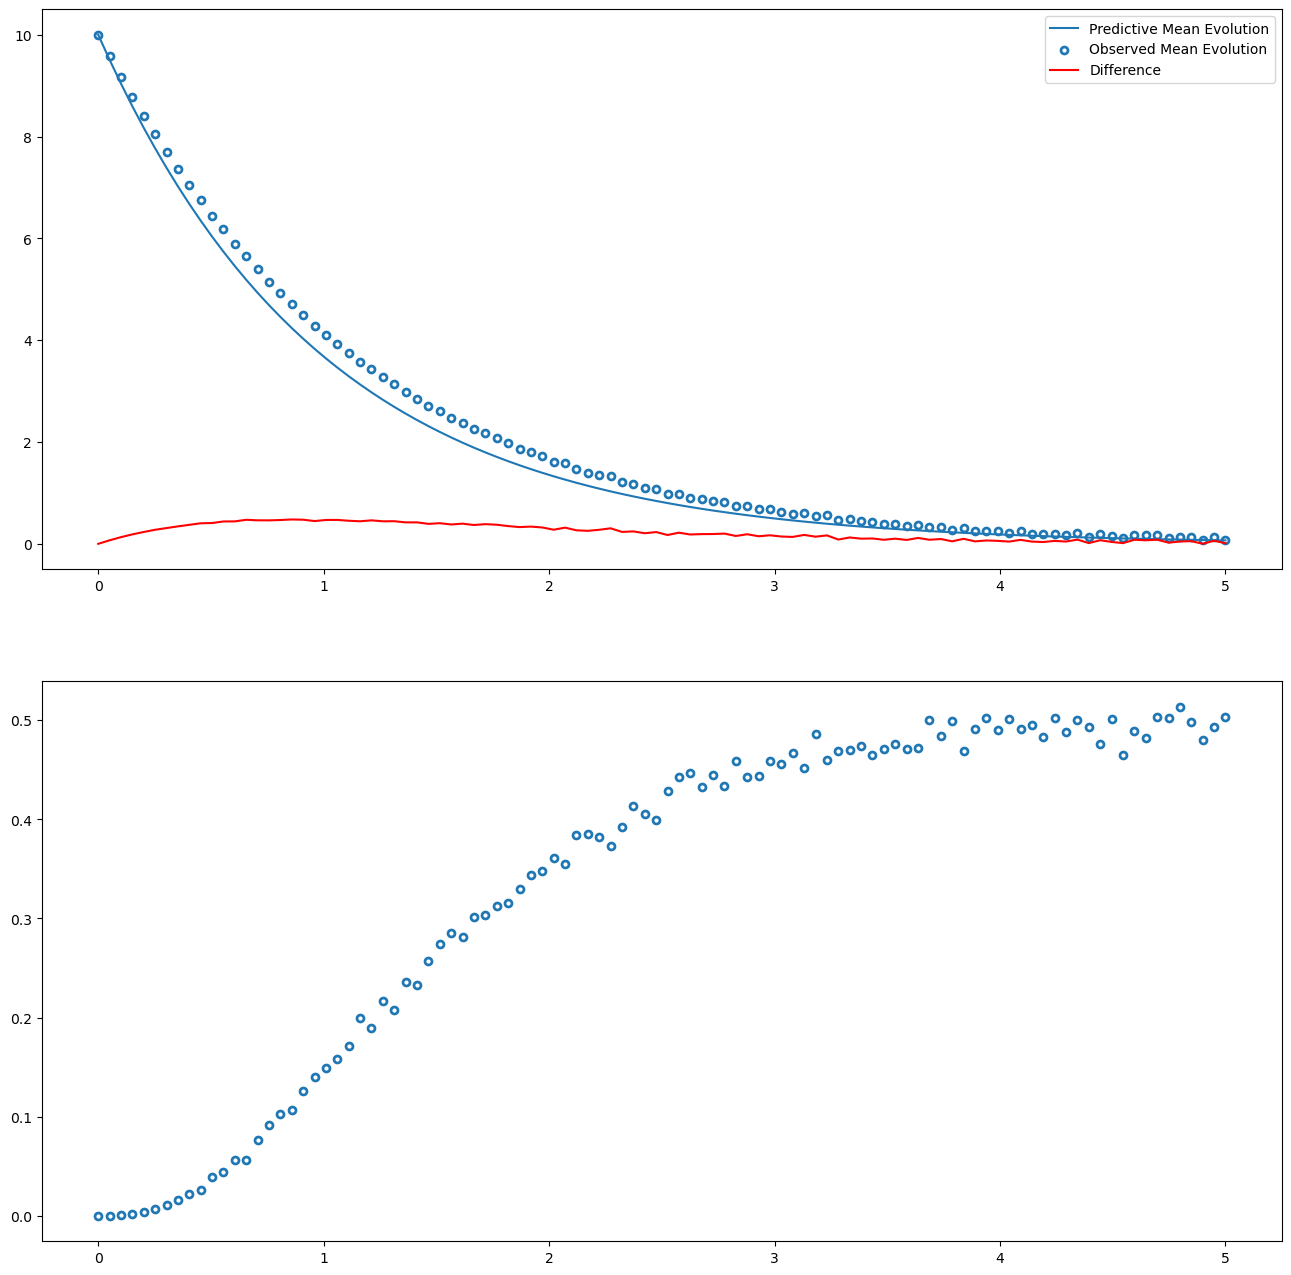

In [36]:
x_0 = 10
v_0 = 1
A = 2
mu = 1
gamma = .5
nt = 100

t_e_1 = 0
t_e_2 = 5
t_e = np.linspace(t_e_1,t_e_2,nt)

NUM =1000
fig,axes = plt.subplots(2,1, figsize = (16,16))
step = np.zeros((nt, NUM))
stepsq = np.zeros((nt, NUM))
step_mean = np.zeros(nt)
step_deviation = np.zeros(nt)

for k in range(0, nt):
    for i in range(0,NUM):    
        c = ModelGen2(x_0, v_0, gamma, t_e[k], mu, A, 20)
        posnobsfl = np.array(c)
        nsteps = len(posnobsfl)
        time = np.linspace(0,t_e[k], nsteps)
        step[k][i] = posnobsfl[-1]    
        stepsq[k][i] = posnobsfl[-1]**2  
          
    step_mean[k] = np.average(step[k])
    step_deviation[k] = np.average(stepsq[k]) - step_mean[k]**2

# t = np.linspace(t_e_1, t_e_2, 1000)
meanevol = x_0 * np.exp(-mu*t_e)
axes[0].plot(t_e, meanevol, label = "Predictive Mean Evolution")
axes[0].scatter(t_e, step_mean, marker = "$\u26AA$",label = "Observed Mean Evolution")
axes[1].scatter(t_e, step_deviation, marker = "$\u26AA$",label = "Observed Variance Evolution")

# axes.plot(t_e, step_mean,label = "Observed Mean Evolution")
axes[0].plot(t_e, abs(step_mean - meanevol), label="Difference", color = "red")

axes[0].legend()
# fig.savefig("RunandTumblegamma1pt5.png")

In [ ]:
def Logl(x_0, v_0, gamma, A, mu, nDT):
    
    return None

94
92
97
89
87
92
93
95
89
91
91
96
96
90
93
95
93
97
93
96
93
94
95
96
90
93
94
96
93
96
93
92
90
94
94
88
95
94
91
96
94
96
92
93
91
95
94
91
92
91
93
96
95
87
93
98
91
89
91
90
94
93
92
91
91
93
97
91
94
86
93
96
98
97
87
91
95
93
93
87
94
95
89
95
91
92
89
93
96
100
94
96
94
93
89
97
92
92
90
92
94
88
90
93
93
97
89
91
89
90
95
91
91
88
94
93
89
90
93
91
94
97
97
92
94
92
89
93
90
87
89
87
95
95
93
95
91
93
89
91
92
92
94
93
98
92
93
92
90
93
96
93
94
90
96
94
88
93
93
95
94
90
95
90
94
98
92
97
87
87
93
89
95
94
90
92
88
93
86
95
94
92
86
98
92
95
94
95
96
94
97
93
93
94
92
93
94
96
98
87
95
93
94
92
94
91
91
98
86
89
93
88
92
91
84
87
96
95
97
91
97
90
90
91
94
96
97
90
95
90
88
95
96
92
92
88
90
97
96
91
92
88
94
98
87
92
88
96
90
90
88
90
96
84
95
91
94
94
84
91
93
97
91
86
100
91
90
96
90
90
93
87
91
95
98
95
93
92
93
83
94
87
92
91
96
93
88
90
93
85
97
89
93
93
90
92
87
95
94
92
88
93
96
92
89
96
93
91
87
96
86
92
91
90
95
94
89
95
93
92
95
94
87
93
91
91
87
94
94
98
92
94
89

/tmp/ipykernel_1077/2621421318.py:5: RuntimeWarning: divide by zero encountered in power
  p = 2/(4**fr * bet) * (mu/v_0) *(1 - (mu*x/v_0)**2)**phi


(0.0, 5.284569918549352)

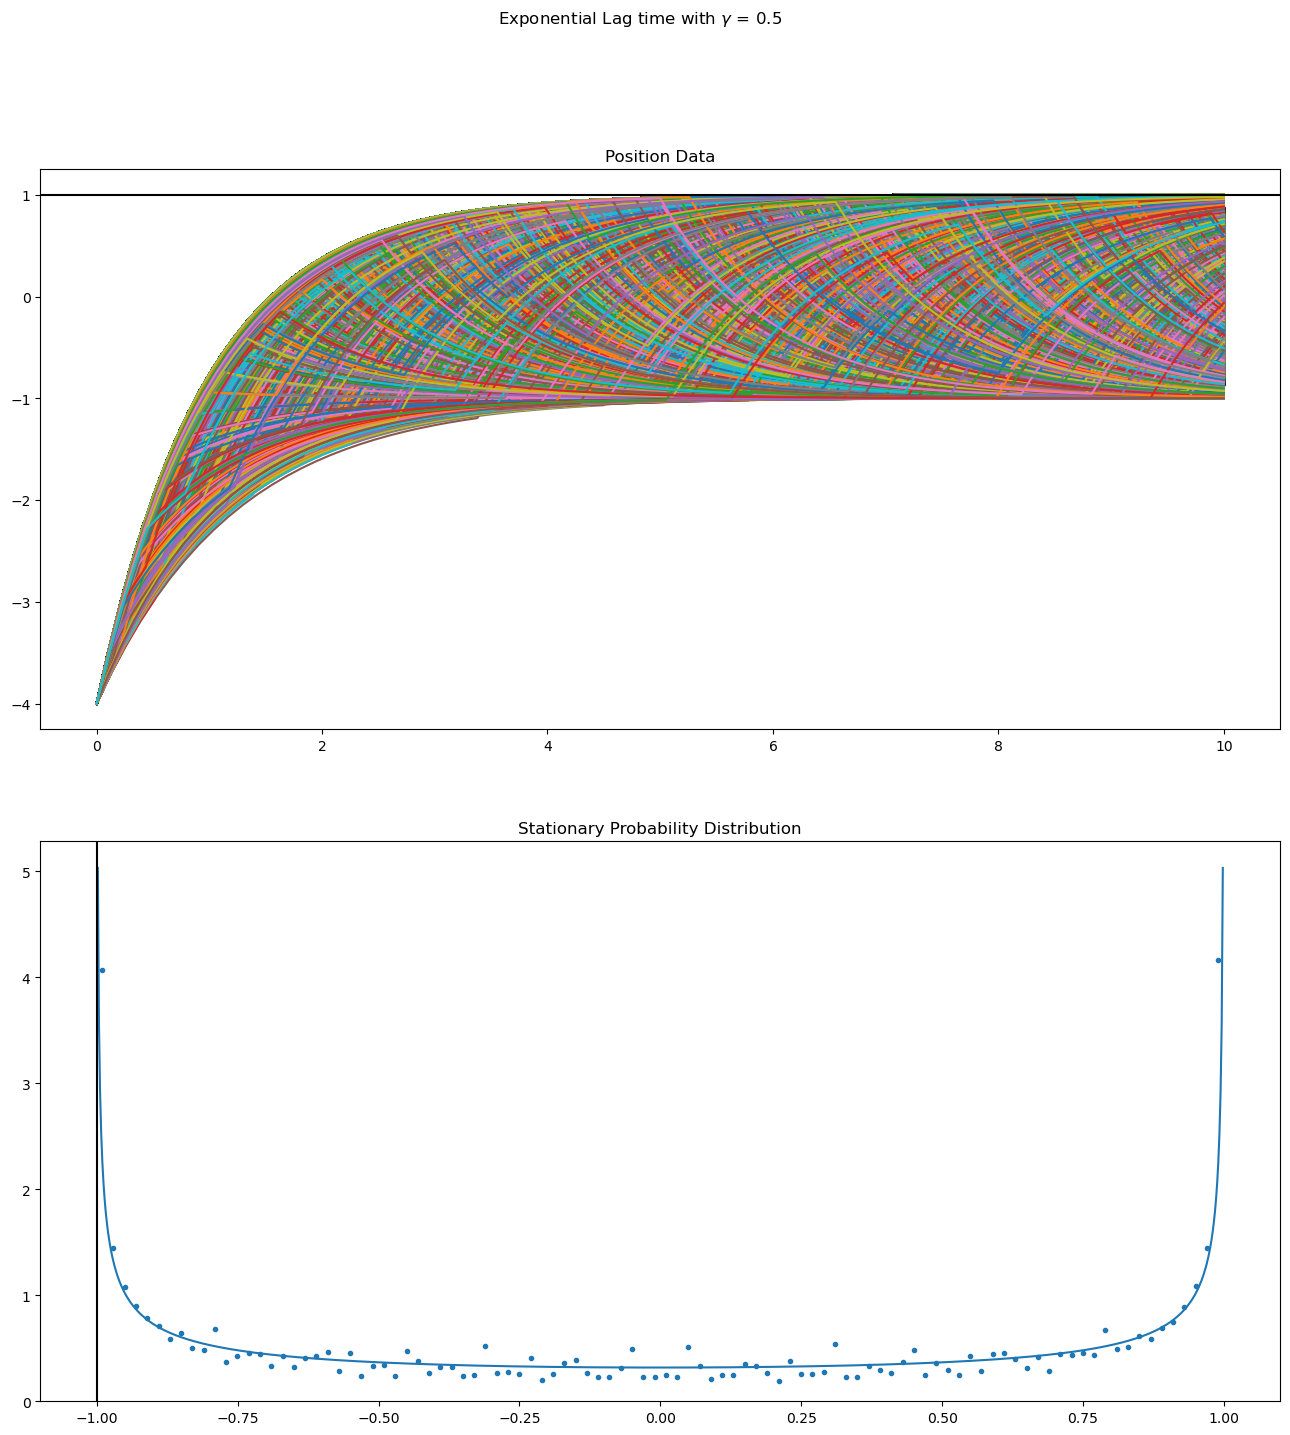

In [28]:
x_0 = -4
v_0 = 1
A = 2
mu = 1
gamma = .5
t_e = 10
# nsteps = 5
NUM =100000
fig,axes = plt.subplots(2,1, figsize = (16,16))
fig.suptitle(r"Exponential Lag time with $\gamma$ = "+str(gamma))
step = np.zeros(NUM)
for i in range(0,NUM):    
    c = ModelGen3(x_0, v_0, gamma, t_e, mu, A, .1)
    posnobsfl = np.array(c)
    nsteps = len(posnobsfl)
    print(nsteps)
    time = np.linspace(0,t_e, nsteps)
    step[i] = posnobsfl[-1]
    axes[0].plot(time, posnobsfl)


n,bins, patches = axes[1].hist(step, bins = 70, density = True, color = 'w');

# Now we find the center of each bin from the bin edges
bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]
# axes[1] = fig.add_subplot(122)
# axes[1].scatter(bins_mean, n,marker="$\u26AA$" )
axes[1].scatter(bins_mean, n,marker="." )
axes[1].set_title("Stationary Probability Distribution")
axes[0].set_title("Position Data")

lll = np.linspace(-1,1, 1000)
lly = prob(lll, gamma, mu, v_0)
axes[1].plot(lll,lly)
axes[0].axhline(v_0/mu, color = 'black')
axes[1].axvline(-v_0/mu, color = 'black')
axes[1].set_ylim(bottom = 0)
# axes[1].set_ylim((0,1))
# fig.savefig("RunandTumblegamma1pt5.png")


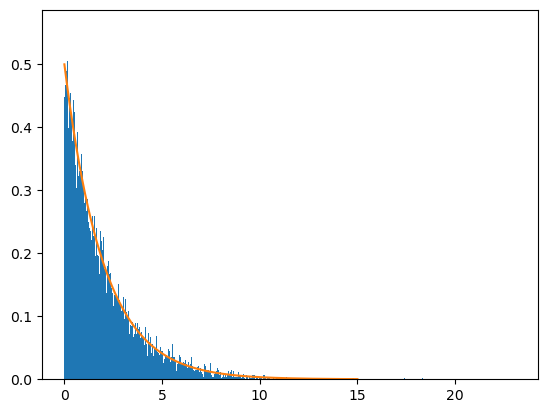

In [84]:
l = expon.rvs(0,1/gamma, 100000, random_state=1)
x = np.linspace(0,15, 1000)
lx = stats.expon.pdf(x,scale = 1/gamma)
plt.hist(l, bins = 5000, density =True)
plt.plot(x,lx)